### *This file allows to initialize a STG spiking neuron as well as neuromodulating them in a robust way with a controller*

# **Useful packages and functions**

In [29]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings, Random, Dierckx, DelimitedFiles
using Interpolations
include("STG_kinetics.jl") # Loading of STG kinetics of gating variables
include("STG_models.jl") # Loading of STG model
include("STG_utils.jl") # Loading of some utils functions
include("STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("STG_neuromodulation.jl") # Loading of the neuromodulation cells functions
include("STG_large_simulations.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [30]:
# Definition of simulation time (in ms)
const Tfinal = 300000
const tspan  = (0.0, Tfinal)
const tspan_half  = (0.0, Tfinal/2)

# Definition of reversal potential values (in mV) and membrane capacitance
const VNa   = 50. # Sodium reversal potential
const VK    = -80. # Potassium reversal potential
const VCa   = 80. # Calcium reversal potential
const VH    = -20. # Reversal potential for the H-current (permeable to both sodium and potassium ions)
const Vleak = -50. # Reversal potential of leak channels
const C     = 1. # Membrane capacitance

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

# Modifying backend GR attributes
gr(guidefontsize=18, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1)
default(fmt = :png)

# Moving average function
moving_average(vs, n, padding) = [sum(vs[i:(i+n-1)])/n for i in 1:padding:(length(vs)-(n-1))];

# **Neuromodulation gCaS and gA overall**

## **Computation of gCaS and gA**

In [31]:
# Fixing random seed
Random.seed!(544)

# Initial firing pattern
guth = 4.
Vth = -50.
(g_all_init, ICs_th_init) = degeneracy_fixDICs_neuromod(ncells, 5., guth, Vth)
(g_all_spiking, ICs_th_spiking) = neuromodCaSA(ncells, g_all_init, ICs_th_init, 5., guth);
# create a spiking set with max variability in gCaS and gA

In [32]:
# Definition of homeostatic parameters
tau_g = 100 # Conductance time constant
tau_Na = 600 # Sodium integral action time constants
Ca_tgt(t) = 125. # Calcium target

# Input current definition
Iapp = 0.

tt = 0. : 0.2 : Tfinal
tt_short = 0. : 0.2 : Tfinal/2

window_size_s = 5
padding_s = 0.2
window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2
tt_moving_average_plot = range(0, Tfinal/1e3, length(tt_moving_average_));

In [5]:
# gNa_matrix, gCaT_matrix, gCaS_matrix, gA_matrix, gKCa_matrix, gKd_matrix, gH_matrix, 
# gleak_matrix, Ca_ma_matrix, burstiness_after = simulate_STG_population(g_all_spiking, 
#                                                                       Iapp, tau_Na, tau_g, Ca_tgt,
#                                                                       C, ICs_th_init, tt_short)

Computing... 100%|███████████████████████████████████████| Time: 1:39:39


([3951.841916097891 4087.7906032980823 … 357.73618364815576 325.3656201062958; 6206.16483952284 6263.864826232644 … 603.2507994473062 600.596812780684; … ; 5828.81555898686 5939.289813406615 … 569.988701853243 627.6415900671678; 3647.552374176823 3788.94738813424 … 311.19978857768467 343.6366105118045], [2.9127829553262314 3.0129866140967425 … 0.26367650335071685 0.23981714162993423; 8.240498245324954 8.317111846724877 … 0.8009918013589973 0.7974678581453694; … ; 3.7236085851028173 3.7941825941836207 … 0.36412454677033546 0.40095480625216273; 1.6468570689115487 1.710696420443051 … 0.14050561008894155 0.155150721115579], [3.8743576320209683 4.007640755435309 … 68.88116836646553 68.84943249681926; 9.131227562797191 9.216122457251563 … 45.66933360897785 45.66542875681406; … ; 5.013166082440555 5.108181232540156 … 65.0660340865485 65.11561937550184; 6.693124989570445 6.952579660603817 … 68.15389716652409 68.2134175465484], [175.2144922072559 181.2421068486693 … -430.148567204863 -431.58379

In [8]:
# writedlm("./data/gNa_matrix.dat", gNa_matrix)
# writedlm("./data/gCaT_matrix.dat", gCaT_matrix)
# writedlm("./data/gCaS_matrix.dat", gCaS_matrix)
# writedlm("./data/gA_matrix.dat", gA_matrix)
# writedlm("./data/gKCa_matrix.dat", gKCa_matrix)
# writedlm("./data/gKd_matrix.dat", gKd_matrix)
# writedlm("./data/gH_matrix.dat", gH_matrix)
# writedlm("./data/gleak_matrix.dat", gleak_matrix)
# writedlm("./data/Ca_ma_matrix.dat", Ca_ma_matrix)
# writedlm("./data/burstiness_after.dat", burstiness_after)

In [33]:
gNa_matrix = readdlm("./data/gNa_matrix.dat")
gCaT_matrix = readdlm("./data/gCaT_matrix.dat")
gCaS_matrix = readdlm("./data/gCaS_matrix.dat")
gA_matrix = readdlm("./data/gA_matrix.dat")
gKCa_matrix = readdlm("./data/gKCa_matrix.dat")
gKd_matrix = readdlm("./data/gKd_matrix.dat")
gH_matrix = readdlm("./data/gH_matrix.dat")
gleak_matrix = readdlm("./data/gleak_matrix.dat")
Ca_ma_matrix = readdlm("./data/Ca_ma_matrix.dat")
burstiness_after = readdlm("./data/burstiness_after.dat");

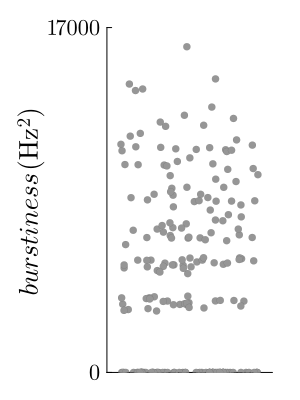

In [6]:
Random.seed!(2022)
burstiness_after[findall(isnan.(burstiness_after))] .= 0
p2b = scatter(rand(ncells), burstiness_after, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 17000], [L"0", L"17000"]), tickfontsize=15, 
             xticks=false, size=(300, 400))

ylabel!(L"burstiness\,\mathrm{(Hz^2)}")
xlims!((-0.1, 1.1))
ylims!((0, 17000))
display(p2b)
# savefig(p2b, "./figures/STG_burstiness_after_crash.pdf")

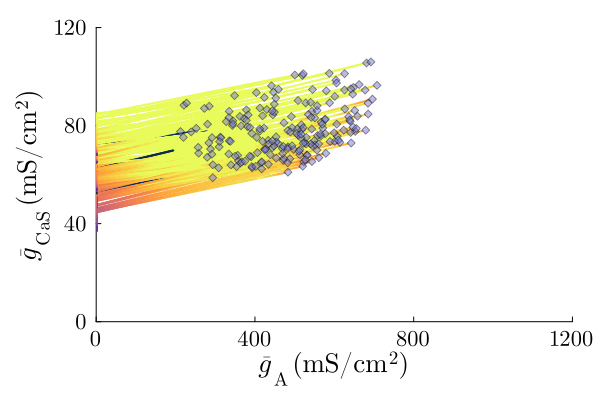

In [39]:
p1 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 400, 800, 1200], [L"0", L"400", L"800", L"1200"]), 
          yticks=([0, 40, 80, 120], [L"0", L"40", L"80", L"120"]))
for i = 1 : ncells
    if i != 86
        # Interpolating
        i_nmodtt = 1
        interpA = linear_interpolation(tt[Int(round(end/2))+i_nmodtt*5000:5000:end]./1e3, gA_matrix[i, Int(end/2)+i_nmodtt:end], extrapolation_bc=Line())
        interpCaS = linear_interpolation(tt[Int(round(end/2))+i_nmodtt*5000:5000:end]./1e3, gCaS_matrix[i, Int(end/2)+i_nmodtt:end], extrapolation_bc=Line())

        # Storing
        t_max_nmod = tt[Int(round(end/2))+i_nmodtt*5000]
        i_after = findall(tt_moving_average_plot .> t_max_nmod/1e3)
        gA_plot_Ca = interpA(tt_moving_average_plot[i_after])
        gCaS_plot_Ca = interpCaS(tt_moving_average_plot[i_after])

        # Plotting
        plot!(max.(0., gA_plot_Ca), gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, i_after], grid=false, c=:thermal,
              linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
    end
end

for i = 1 : ncells
    if i != 86
        i_nmodtt = 1
        scatter!([gA_matrix[i, Int(end/2)+i_nmodtt]], [gCaS_matrix[i, Int(end/2)+i_nmodtt]], 
        color=myDarkBlue, alpha=0.5, marker=:diamond)
    end
end

# for i = 1 : ncells
#     if i != 86
#         scatter!([max.(0., gA_matrix[i, end])], [gCaS_matrix[i, end]], 
#             color=myGreen, alpha=0.5, marker=:utriangle)
#     end
# end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p1)
# savefig(p1, "./figures/gCaSgA_nmod_crash.pdf")

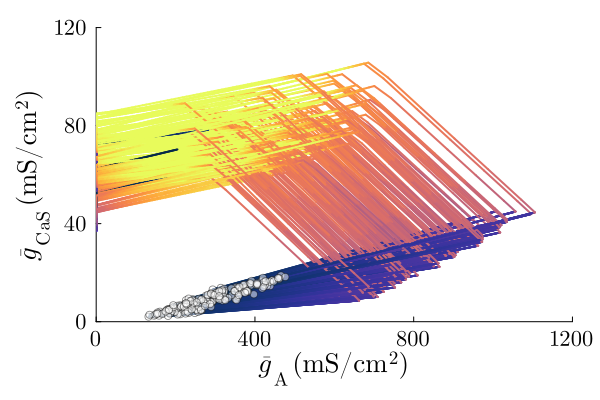

In [35]:
p9 = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
          xticks=([0, 400, 800, 1200], [L"0", L"400", L"800", L"1200"]), 
          yticks=([0, 40, 80, 120], [L"0", L"40", L"80", L"120"]))
for i = 1 : ncells
    if i != 86
        # Interpolating
        interpA = linear_interpolation(tt[2:5000:end]./1e3, gA_matrix[i, :], extrapolation_bc=Line())
        interpCaS = linear_interpolation(tt[2:5000:end]./1e3, gCaS_matrix[i, :], extrapolation_bc=Line())

        # Storing
        gA_plot_Ca = interpA(tt_moving_average_plot)
        gCaS_plot_Ca = interpCaS(tt_moving_average_plot)

        # Plotting
        plot!(max.(0., gA_plot_Ca), gCaS_plot_Ca, label="", line_z=Ca_ma_matrix[i, :], grid=false, c=:thermal,
              linewidth=2, clim=(0, 500), yguidefontsize=18, xguidefontsize=18, alpha=1)
    end
end

for i = 1 : ncells
    if i != 86
        scatter!([gA_matrix[i, 1]], [gCaS_matrix[i, 1]], color=:white, alpha=0.5)
    end
end

xlims!((0, 1200))
ylims!((0, 120))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")

display(p9)
# savefig(p9, "./figures/gCaSgA_crash.pdf")

In [16]:
frequency_before = readdlm("./data/frequency_before.dat")
burstiness_acute = readdlm("./data/burstiness_acute.dat")
burstiness_end = readdlm("./data/burstiness_after.dat");

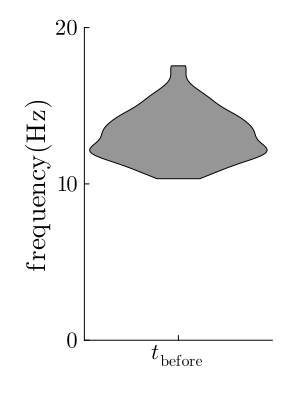

In [28]:
violin_f = violin([frequency_before], label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10, 20], [L"0", L"10", L"20"]), tickfontsize=15, 
             xticks=([1,], [L"t_\mathrm{before}",]), size=(300, 400))

ylabel!(L"\mathrm{frequency}\,\mathrm{(Hz)}")
ylims!((0, 20))
display(violin_f)
# savefig(violin_f, "./figures/violins_frequency_crash.pdf")

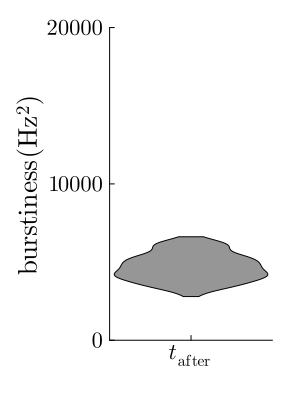

In [27]:
violin_after = violin(burstiness_acute, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000, 20000], [L"0", L"10000", L"20000"]), tickfontsize=15, 
             xticks=([1], [L"t_\mathrm{after}"]), size=(300, 400))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 20000))
display(violin_after)
# savefig(violin_after, "./figures/violin_burstiness_acute_crash.pdf")

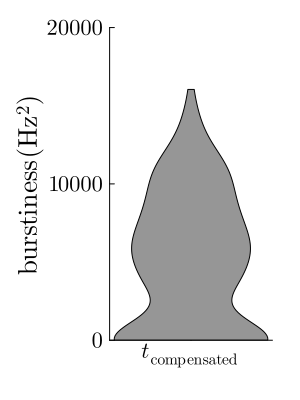

In [26]:
violin_compensated = violin(burstiness_end, label="", color=myGray, grid=false,
             yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
             markerstrokewidth=0., yticks=([0, 10000, 20000], [L"0", L"10000", L"20000"]), tickfontsize=15, 
             xticks=([1], [L"t_\mathrm{compensated}"]), size=(300, 400))

ylabel!(L"\mathrm{burstiness}\,\mathrm{(Hz^2)}")
ylims!((0, 20000))
display(violin_compensated)
# savefig(violin_compensated, "./figures/violin_burstiness_compensated_crash.pdf")

In [2]:
# # Initializing some variables
#     gNa_matrix = zeros(ncells, length(tt[2:5000:end]))
#     gCaT_matrix = zero(gNa_matrix)
#     gCaS_matrix = zero(gNa_matrix)
#     gA_matrix = zero(gNa_matrix)
#     gKCa_matrix = zero(gNa_matrix)
#     gKd_matrix = zero(gNa_matrix)
#     gH_matrix = zero(gNa_matrix)
#     gleak_matrix = zero(gNa_matrix)

#     window_size_s = 5
#     padding_s = 0.2
#     window_size_ = Int64(round(window_size_s*1000*length(tt)/(Tfinal)))
#     padding_ = Int64(round(padding_s*1000*length(tt)/(Tfinal)))
#     tt_moving_average_ = window_size_s/2 : padding_s : Tfinal/1000 - window_size_s/2

#     Ca_ma_matrix = zeros(ncells, length(tt_moving_average_));

In [10]:
# # Simulate to initial blockade conditions
#         sol = simulate_STG(g_all_init[i, :], Iapp, tau_Na, tau_g, Ca_tgt, C)

#         # Retrieving variables
# x = sol(tt_short[2:5000:end]);

In [11]:
# g_all_crash = [x[14, end], x[15, end], x[16, end], x[17, end], x[18, end], x[19, end], x[20, end], x[21, end]]
#         sol_crash = simulate_STG_crash(g_all_crash, Iapp, tau_Na, tau_g, Ca_tgt, C, ICs_th_init[:, 1][i])

In [12]:
# x_crash = sol_crash(tt_short[2:5000:end]);

In [13]:
# plot(x[16, :])

In [14]:
# plot(x_crash[16, :])

In [15]:
# i=1
# sol = simulate_STG(g_all_init[i, :], Iapp, tau_Na, tau_g, Ca_tgt, C)

#         # Retrieving variables
# x = sol(tt_short[2:5000:end]);

In [16]:
# g_all_init[i, :]

In [17]:
# plot(x[16, :])

In [18]:
# g_all_crash = [x[14, end], x[15, end], x[16, end], x[17, end], x[18, end], x[19, end], x[20, end], x[21, end]]

In [19]:
# (gNa_c, gCaT_c, gCaS_c, gA_c, gKCa_c, gKd_c, gH_c, gleak_c) = g_all_crash

In [20]:
# VVth = ICs_th_init[:, 1][i]

In [21]:
# (gCaS_crash, gA_crash) = DICs_gmax_neuromodCaSA(gNa_c, gCaT_c,
#         gKd_c, gKCa_c, gH_c, gleak_c, -8., 4., VVth)

In [22]:
# (gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_init;

In [23]:
# tau_CaT = tau_Na * gNa / gCaT
#     tau_KCa = tau_Na * gNa / gKCa
#     tau_Kd = tau_Na * gNa / gKd
#     tau_H = tau_Na * gNa / gH
#     tau_leak = tau_Na * gNa / gleak
#     tau_CaS = tau_Na * gNa / gCaS
#     tau_A = tau_Na * gNa / gA

In [24]:
# p = [Iapp, tau_Na, tau_CaT, tau_CaS, tau_A, tau_KCa, tau_Kd, tau_H, tau_leak, tau_g, Ca_tgt, C]

#      # Initial conditions
#      V0  = -70.
#      Ca0 = 0.5
#      x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), hCaS_inf(V0),
#           mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0,
#           gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak,
#           gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak]

#     # Simulation
#     prob = ODEProblem(STG_homeo_leak_ODE, x0, tspan_half, p) # Describing the problem
#     sol = solve(prob) # Solving the problem;

In [25]:
# x = sol(tt_short[2:5000:end])

In [26]:
# plot(x[1, :])

In [27]:
# g_all_crash = [x[14, end], x[15, end], x[16, end], x[17, end], x[18, end], x[19, end], x[20, end], x[21, end]]

In [28]:
# (gNa_ci, gCaT_ci, gCaS_ci, gA_ci, gKCa_ci, gKd_ci, gH_ci, gleak_ci) = g_all_crash

#     (gCaS_crash, gA_crash) = DICs_gmax_neuromodCaSA(gNa_ci, gCaT_ci,
#         gKd_ci, gKCa_ci, gH_ci, gleak_ci, -8., 4., Vth)